# Train Low Test Models

This notebook is a streamlined notebook for generating minima of low test accuracy through three different means:
- Dataset Poisoning
- Adding Noise to Data
- Decreasing Dataset Sizes

## Imports

In [1]:
# Standard library
import copy
import os
import sys
import time

# Third-party
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Local package imports
from minima_volume.dataset_funcs import (
    prepare_datasets,
    save_dataset,
    save_model,
)
from minima_volume.train_funcs import evaluate, train

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Input Parameters

In [2]:

# ==============================
# Base Input Parameters
# ==============================
# --- SEEDS ---
data_seed = 10            
model_seed = 0           

# --- Training configuration ---
epochs = 2000            

# --- Dataset configuration ---
base_data_size = 60      
dataset_type = "data"   
dataset_quantities = [0, 600-60, 2000 - 60, 6000 - 60, 20000 - 60, 60000 - 60]

# --- Output configuration ---
base_output_dir = ""     
save_generated_dataset = True   
save_generated_models = True    


## Model + Dataset Specific Code

This is for specific code.

In [3]:
# User specifies the model module name
from minima_volume.models import Fashion_MNIST_model_data as model_module

# Generate dataset
x_base, y_base, x_test, y_test = model_module.get_dataset(
    device = device
)

# MNIST specific initialization parameters
hidden_dims = [256, 128]

# Grab model
model_template = model_module.get_model(hidden_dims=hidden_dims, device=device, seed=model_seed)

# Grab loss and metrics
loss_fn = model_module.get_loss_fn()
other_metrics = model_module.get_additional_metrics()

## Training

We generate the various datasets used to train our models here, before training them. We record the losses, and what each model was trained on.

In [4]:
# ==============================
# Prepare datasets
# ==============================
x_base_train, y_base_train, x_additional, y_additional = prepare_datasets(
    x_base=x_base,
    y_base=y_base,
    dataset_type=dataset_type,
    dataset_quantities=dataset_quantities,
    base_data_size=base_data_size,
    data_seed=data_seed,
    seed_1=None,
    seed_2=None,
)

x_base_train = x_base_train.to(device)
y_base_train = y_base_train.to(device)
x_additional = x_additional.to(device)
y_additional = y_additional.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

# ==============================
# Training loop
# ==============================
all_models = []

for additional_data in dataset_quantities:
    # Assemble training dataset
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    # Initialize model (defined in the model-specific file)
    torch.manual_seed(model_seed)
    model = copy.deepcopy(model_template)
    optimizer = optim.AdamW(model.parameters(), lr=1e-3)
    batch_size = len(x_train)

    # Train model
    train_loss, train_other_metrics, test_loss, test_other_metrics = train(
        model = model,
        x_train = x_train, y_train = y_train,
        x_test = x_test, y_test = y_test,
        loss_fn = loss_fn,
        metrics = other_metrics,
        optimizer = optimizer,
        epochs=epochs,
        batch_size=batch_size,
        verbose_every=100,
    )
    
    # Build dictionary dynamically for additional metrics
    train_metrics_dict = {}
    test_metrics_dict = {}
    if train_other_metrics is not None:
        # train_other_metrics is a list of dicts per epoch
        for metric_name in train_other_metrics[0].keys():  # keys from first epoch
            train_metrics_dict[f"train_{metric_name}"] = [m[metric_name] for m in train_other_metrics]
            test_metrics_dict[f"test_{metric_name}"] = [m[metric_name] for m in test_other_metrics]
    
    # Store results
    trained_model = {
        "model": model,
        "train_loss": train_loss,
        "test_loss": test_loss,
        "additional_data": additional_data,
        "dataset_type": dataset_type,
        **train_metrics_dict,  # dynamically include additional metrics
        **test_metrics_dict,
    }
    
    all_models.append(trained_model)

    print(f"Completed training with {additional_data} additional samples of {dataset_type}")

    # Free memory (important for large GPU datasets)
    del x_train, y_train
    torch.cuda.empty_cache()


Epoch 1/2000: Train Loss 2.3240 | Test Loss 2.1812 | accs Train 0.0667 Test 0.2695


Epoch 100/2000: Train Loss 0.0004 | Test Loss 1.7165 | accs Train 1.0000 Test 0.6838


Epoch 200/2000: Train Loss 0.0002 | Test Loss 1.7917 | accs Train 1.0000 Test 0.6832


Epoch 300/2000: Train Loss 0.0001 | Test Loss 1.8476 | accs Train 1.0000 Test 0.6826


Epoch 400/2000: Train Loss 0.0001 | Test Loss 1.8930 | accs Train 1.0000 Test 0.6826


Epoch 500/2000: Train Loss 0.0001 | Test Loss 1.9311 | accs Train 1.0000 Test 0.6830


Epoch 600/2000: Train Loss 0.0000 | Test Loss 1.9642 | accs Train 1.0000 Test 0.6831


Epoch 700/2000: Train Loss 0.0000 | Test Loss 1.9932 | accs Train 1.0000 Test 0.6831


Epoch 800/2000: Train Loss 0.0000 | Test Loss 2.0194 | accs Train 1.0000 Test 0.6833


Epoch 900/2000: Train Loss 0.0000 | Test Loss 2.0431 | accs Train 1.0000 Test 0.6832


Epoch 1000/2000: Train Loss 0.0000 | Test Loss 2.0648 | accs Train 1.0000 Test 0.6829


Epoch 1100/2000: Train Loss 0.0000 | Test Loss 2.0847 | accs Train 1.0000 Test 0.6827


Epoch 1200/2000: Train Loss 0.0000 | Test Loss 2.1033 | accs Train 1.0000 Test 0.6827


Epoch 1300/2000: Train Loss 0.0000 | Test Loss 2.1208 | accs Train 1.0000 Test 0.6824


Epoch 1400/2000: Train Loss 0.0000 | Test Loss 2.1373 | accs Train 1.0000 Test 0.6826


Epoch 1500/2000: Train Loss 0.0000 | Test Loss 2.1528 | accs Train 1.0000 Test 0.6826


Epoch 1600/2000: Train Loss 0.0000 | Test Loss 2.1675 | accs Train 1.0000 Test 0.6829


Epoch 1700/2000: Train Loss 0.0000 | Test Loss 2.1813 | accs Train 1.0000 Test 0.6831


Epoch 1800/2000: Train Loss 0.0000 | Test Loss 2.1944 | accs Train 1.0000 Test 0.6833


Epoch 1900/2000: Train Loss 0.0000 | Test Loss 2.2072 | accs Train 1.0000 Test 0.6832


Epoch 2000/2000: Train Loss 0.0000 | Test Loss 2.2193 | accs Train 1.0000 Test 0.6832
Completed training with 0 additional samples of data
Epoch 1/2000: Train Loss 2.3251 | Test Loss 2.1490 | accs Train 0.0567 Test 0.5299


Epoch 100/2000: Train Loss 0.0063 | Test Loss 0.9822 | accs Train 1.0000 Test 0.7873


Epoch 200/2000: Train Loss 0.0013 | Test Loss 1.1756 | accs Train 1.0000 Test 0.7853


Epoch 300/2000: Train Loss 0.0006 | Test Loss 1.2768 | accs Train 1.0000 Test 0.7864


Epoch 400/2000: Train Loss 0.0003 | Test Loss 1.3481 | accs Train 1.0000 Test 0.7867


Epoch 500/2000: Train Loss 0.0002 | Test Loss 1.4027 | accs Train 1.0000 Test 0.7858


Epoch 600/2000: Train Loss 0.0001 | Test Loss 1.4468 | accs Train 1.0000 Test 0.7853


Epoch 700/2000: Train Loss 0.0001 | Test Loss 1.4839 | accs Train 1.0000 Test 0.7845


Epoch 800/2000: Train Loss 0.0001 | Test Loss 1.5161 | accs Train 1.0000 Test 0.7840


Epoch 900/2000: Train Loss 0.0001 | Test Loss 1.5459 | accs Train 1.0000 Test 0.7841


Epoch 1000/2000: Train Loss 0.0001 | Test Loss 1.5717 | accs Train 1.0000 Test 0.7839


Epoch 1100/2000: Train Loss 0.0000 | Test Loss 1.5952 | accs Train 1.0000 Test 0.7846


Epoch 1200/2000: Train Loss 0.0000 | Test Loss 1.6167 | accs Train 1.0000 Test 0.7844


Epoch 1300/2000: Train Loss 0.0000 | Test Loss 1.6368 | accs Train 1.0000 Test 0.7844


Epoch 1400/2000: Train Loss 0.0000 | Test Loss 1.6556 | accs Train 1.0000 Test 0.7843


Epoch 1500/2000: Train Loss 0.0000 | Test Loss 1.6733 | accs Train 1.0000 Test 0.7839


Epoch 1600/2000: Train Loss 0.0000 | Test Loss 1.6898 | accs Train 1.0000 Test 0.7844


Epoch 1700/2000: Train Loss 0.0000 | Test Loss 1.7051 | accs Train 1.0000 Test 0.7846


Epoch 1800/2000: Train Loss 0.0000 | Test Loss 1.7199 | accs Train 1.0000 Test 0.7849


Epoch 1900/2000: Train Loss 0.0000 | Test Loss 1.7341 | accs Train 1.0000 Test 0.7850


Epoch 2000/2000: Train Loss 0.0000 | Test Loss 1.7475 | accs Train 1.0000 Test 0.7851
Completed training with 540 additional samples of data
Epoch 1/2000: Train Loss 2.3229 | Test Loss 2.1439 | accs Train 0.0585 Test 0.5190


Epoch 100/2000: Train Loss 0.0683 | Test Loss 0.6210 | accs Train 0.9905 Test 0.8236


Epoch 200/2000: Train Loss 0.0056 | Test Loss 0.8991 | accs Train 1.0000 Test 0.8204


Epoch 300/2000: Train Loss 0.0018 | Test Loss 1.0374 | accs Train 1.0000 Test 0.8206


Epoch 400/2000: Train Loss 0.0009 | Test Loss 1.1247 | accs Train 1.0000 Test 0.8205


Epoch 500/2000: Train Loss 0.0006 | Test Loss 1.1898 | accs Train 1.0000 Test 0.8200


Epoch 600/2000: Train Loss 0.0004 | Test Loss 1.2417 | accs Train 1.0000 Test 0.8188


Epoch 700/2000: Train Loss 0.0003 | Test Loss 1.2856 | accs Train 1.0000 Test 0.8187


Epoch 800/2000: Train Loss 0.0002 | Test Loss 1.3237 | accs Train 1.0000 Test 0.8178


Epoch 900/2000: Train Loss 0.0002 | Test Loss 1.3572 | accs Train 1.0000 Test 0.8180


Epoch 1000/2000: Train Loss 0.0001 | Test Loss 1.3863 | accs Train 1.0000 Test 0.8185


Epoch 1100/2000: Train Loss 0.0001 | Test Loss 1.4123 | accs Train 1.0000 Test 0.8188


Epoch 1200/2000: Train Loss 0.0001 | Test Loss 1.4361 | accs Train 1.0000 Test 0.8190


Epoch 1300/2000: Train Loss 0.0001 | Test Loss 1.4584 | accs Train 1.0000 Test 0.8194


Epoch 1400/2000: Train Loss 0.0001 | Test Loss 1.4792 | accs Train 1.0000 Test 0.8193


Epoch 1500/2000: Train Loss 0.0001 | Test Loss 1.4980 | accs Train 1.0000 Test 0.8192


Epoch 1600/2000: Train Loss 0.0000 | Test Loss 1.5160 | accs Train 1.0000 Test 0.8194


Epoch 1700/2000: Train Loss 0.0000 | Test Loss 1.5330 | accs Train 1.0000 Test 0.8193


Epoch 1800/2000: Train Loss 0.0000 | Test Loss 1.5491 | accs Train 1.0000 Test 0.8198


Epoch 1900/2000: Train Loss 0.0000 | Test Loss 1.5652 | accs Train 1.0000 Test 0.8194


Epoch 2000/2000: Train Loss 0.0000 | Test Loss 1.5803 | accs Train 1.0000 Test 0.8196
Completed training with 1940 additional samples of data
Epoch 1/2000: Train Loss 2.3234 | Test Loss 2.1415 | accs Train 0.0587 Test 0.5208


Epoch 100/2000: Train Loss 0.2164 | Test Loss 0.4531 | accs Train 0.9303 Test 0.8483


Epoch 200/2000: Train Loss 0.0684 | Test Loss 0.5558 | accs Train 0.9870 Test 0.8424


Epoch 300/2000: Train Loss 0.0196 | Test Loss 0.7100 | accs Train 0.9997 Test 0.8433


Epoch 400/2000: Train Loss 0.0067 | Test Loss 0.8441 | accs Train 1.0000 Test 0.8421


Epoch 500/2000: Train Loss 0.0032 | Test Loss 0.9403 | accs Train 1.0000 Test 0.8416


Epoch 600/2000: Train Loss 0.0018 | Test Loss 1.0110 | accs Train 1.0000 Test 0.8406


Epoch 700/2000: Train Loss 0.0012 | Test Loss 1.0663 | accs Train 1.0000 Test 0.8408


Epoch 800/2000: Train Loss 0.0008 | Test Loss 1.1110 | accs Train 1.0000 Test 0.8407


Epoch 900/2000: Train Loss 0.0006 | Test Loss 1.1495 | accs Train 1.0000 Test 0.8411


Epoch 1000/2000: Train Loss 0.0005 | Test Loss 1.1832 | accs Train 1.0000 Test 0.8409


Epoch 1100/2000: Train Loss 0.0004 | Test Loss 1.2129 | accs Train 1.0000 Test 0.8408


Epoch 1200/2000: Train Loss 0.0003 | Test Loss 1.2397 | accs Train 1.0000 Test 0.8405


Epoch 1300/2000: Train Loss 0.0003 | Test Loss 1.2640 | accs Train 1.0000 Test 0.8402


Epoch 1400/2000: Train Loss 0.0002 | Test Loss 1.2863 | accs Train 1.0000 Test 0.8404


Epoch 1500/2000: Train Loss 0.0002 | Test Loss 1.3071 | accs Train 1.0000 Test 0.8403


Epoch 1600/2000: Train Loss 0.0002 | Test Loss 1.3264 | accs Train 1.0000 Test 0.8407


Epoch 1700/2000: Train Loss 0.0001 | Test Loss 1.3445 | accs Train 1.0000 Test 0.8404


Epoch 1800/2000: Train Loss 0.0001 | Test Loss 1.3614 | accs Train 1.0000 Test 0.8407


Epoch 1900/2000: Train Loss 0.0001 | Test Loss 1.3778 | accs Train 1.0000 Test 0.8406


Epoch 2000/2000: Train Loss 0.0001 | Test Loss 1.3932 | accs Train 1.0000 Test 0.8410
Completed training with 5940 additional samples of data
Epoch 1/2000: Train Loss 2.3232 | Test Loss 2.1405 | accs Train 0.0598 Test 0.4965


Epoch 100/2000: Train Loss 0.3196 | Test Loss 0.4023 | accs Train 0.8890 Test 0.8584


Epoch 200/2000: Train Loss 0.2127 | Test Loss 0.3796 | accs Train 0.9269 Test 0.8727


Epoch 300/2000: Train Loss 0.1366 | Test Loss 0.4064 | accs Train 0.9580 Test 0.8713


Epoch 400/2000: Train Loss 0.0898 | Test Loss 0.4636 | accs Train 0.9742 Test 0.8652


Epoch 500/2000: Train Loss 0.0541 | Test Loss 0.5003 | accs Train 0.9896 Test 0.8683


Epoch 600/2000: Train Loss 0.0348 | Test Loss 0.5611 | accs Train 0.9937 Test 0.8657


Epoch 700/2000: Train Loss 0.0208 | Test Loss 0.6214 | accs Train 0.9981 Test 0.8652


Epoch 800/2000: Train Loss 0.0131 | Test Loss 0.6802 | accs Train 0.9995 Test 0.8641


Epoch 900/2000: Train Loss 0.0085 | Test Loss 0.7365 | accs Train 0.9998 Test 0.8621


Epoch 1000/2000: Train Loss 0.0057 | Test Loss 0.7876 | accs Train 1.0000 Test 0.8617


Epoch 1100/2000: Train Loss 0.0040 | Test Loss 0.8355 | accs Train 1.0000 Test 0.8618


Epoch 1200/2000: Train Loss 0.0028 | Test Loss 0.8908 | accs Train 1.0000 Test 0.8613


Epoch 1300/2000: Train Loss 0.0020 | Test Loss 0.9364 | accs Train 1.0000 Test 0.8615


Epoch 1400/2000: Train Loss 0.0016 | Test Loss 0.9767 | accs Train 1.0000 Test 0.8619


Epoch 1500/2000: Train Loss 0.0012 | Test Loss 1.0119 | accs Train 1.0000 Test 0.8619


Epoch 1600/2000: Train Loss 0.0010 | Test Loss 1.0442 | accs Train 1.0000 Test 0.8619


Epoch 1700/2000: Train Loss 0.0008 | Test Loss 1.0731 | accs Train 1.0000 Test 0.8607


Epoch 1800/2000: Train Loss 0.0007 | Test Loss 1.1000 | accs Train 1.0000 Test 0.8606


Epoch 1900/2000: Train Loss 0.0006 | Test Loss 1.1249 | accs Train 1.0000 Test 0.8602


Epoch 2000/2000: Train Loss 0.0005 | Test Loss 1.1477 | accs Train 1.0000 Test 0.8602
Completed training with 19940 additional samples of data
Epoch 1/2000: Train Loss 2.3232 | Test Loss 2.1398 | accs Train 0.0571 Test 0.4897


Epoch 100/2000: Train Loss 0.3415 | Test Loss 0.3913 | accs Train 0.8790 Test 0.8621


Epoch 200/2000: Train Loss 0.2597 | Test Loss 0.3360 | accs Train 0.9067 Test 0.8818


Epoch 300/2000: Train Loss 0.2130 | Test Loss 0.3242 | accs Train 0.9243 Test 0.8874


Epoch 400/2000: Train Loss 0.1748 | Test Loss 0.3270 | accs Train 0.9386 Test 0.8875


Epoch 500/2000: Train Loss 0.1579 | Test Loss 0.3400 | accs Train 0.9441 Test 0.8895


Epoch 600/2000: Train Loss 0.1198 | Test Loss 0.3536 | accs Train 0.9615 Test 0.8886


Epoch 700/2000: Train Loss 0.1051 | Test Loss 0.3769 | accs Train 0.9657 Test 0.8888


Epoch 800/2000: Train Loss 0.0828 | Test Loss 0.3973 | accs Train 0.9758 Test 0.8877


Epoch 900/2000: Train Loss 0.0730 | Test Loss 0.4308 | accs Train 0.9787 Test 0.8859


Epoch 1000/2000: Train Loss 0.0570 | Test Loss 0.4495 | accs Train 0.9856 Test 0.8868


Epoch 1100/2000: Train Loss 0.0627 | Test Loss 0.4916 | accs Train 0.9802 Test 0.8832


Epoch 1200/2000: Train Loss 0.8537 | Test Loss 0.7736 | accs Train 0.8737 Test 0.8646


Epoch 1300/2000: Train Loss 0.0572 | Test Loss 0.4752 | accs Train 0.9852 Test 0.8846


Epoch 1400/2000: Train Loss 0.0445 | Test Loss 0.4993 | accs Train 0.9904 Test 0.8857


Epoch 1500/2000: Train Loss 0.0370 | Test Loss 0.5206 | accs Train 0.9923 Test 0.8851


Epoch 1600/2000: Train Loss 0.0313 | Test Loss 0.5423 | accs Train 0.9941 Test 0.8855


Epoch 1700/2000: Train Loss 0.0264 | Test Loss 0.5671 | accs Train 0.9955 Test 0.8854


Epoch 1800/2000: Train Loss 0.1934 | Test Loss 0.3817 | accs Train 0.9270 Test 0.8762


Epoch 1900/2000: Train Loss 0.1117 | Test Loss 0.4109 | accs Train 0.9612 Test 0.8853


Epoch 2000/2000: Train Loss 0.0772 | Test Loss 0.4589 | accs Train 0.9756 Test 0.8870
Completed training with 59940 additional samples of data


## Training Summary

In [5]:
# ====================================
# Summary of Training Results
# ====================================
print("=== True Generalization ===")
for model_data in all_models:
    model = model_data["model"]
    additional_data = model_data["additional_data"]

    test_loss, test_metrics = evaluate(
        model=model,
        x_test=x_test,
        y_test=y_test,
        loss_fn=loss_fn,
        metrics=other_metrics
    )

    metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in test_metrics.items()])
    print(
        f"{additional_data:>4} samples | "
        f"Test Loss: {test_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
    )

print("\n=== Model Diagnostics by Training Data ===")
for additional_data in dataset_quantities:
    # Build dataset with this many additional samples
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    print(f"\nDataset type: {dataset_type}, additional samples: {additional_data}")

    for model_data in all_models:
        model = model_data["model"]
        model_additional_data = model_data["additional_data"]

        train_loss, train_metrics = evaluate(
            model=model,
            x_test=x_train,
            y_test=y_train,
            loss_fn=loss_fn,
            metrics=other_metrics
        )

        metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in train_metrics.items()])
        print(
            f" Model {model_additional_data:>4} | "
            f"Train Loss: {train_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
        )

    # Free memory if large
    del x_train, y_train
    torch.cuda.empty_cache()

=== True Generalization ===
   0 samples | Test Loss: 2.2193 | accs: 0.6832
 540 samples | Test Loss: 1.7475 | accs: 0.7851
1940 samples | Test Loss: 1.5803 | accs: 0.8196
5940 samples | Test Loss: 1.3932 | accs: 0.8410
19940 samples | Test Loss: 1.1477 | accs: 0.8602
59940 samples | Test Loss: 0.4589 | accs: 0.8870

=== Model Diagnostics by Training Data ===

Dataset type: data, additional samples: 0
 Model    0 | Train Loss: 0.0000 | accs: 1.0000
 Model  540 | Train Loss: 0.0000 | accs: 1.0000
 Model 1940 | Train Loss: 0.0000 | accs: 1.0000
 Model 5940 | Train Loss: 0.0001 | accs: 1.0000
 Model 19940 | Train Loss: 0.0005 | accs: 1.0000
 Model 59940 | Train Loss: 0.0861 | accs: 0.9333

Dataset type: data, additional samples: 540
 Model    0 | Train Loss: 2.0589 | accs: 0.7117
 Model  540 | Train Loss: 0.0000 | accs: 1.0000
 Model 1940 | Train Loss: 0.0000 | accs: 1.0000
 Model 5940 | Train Loss: 0.0001 | accs: 1.0000
 Model 19940 | Train Loss: 0.0006 | accs: 1.0000
 Model 59940 | Trai

 Model 5940 | Train Loss: 1.1212 | accs: 0.8659


 Model 19940 | Train Loss: 0.6883 | accs: 0.9128
 Model 59940 | Train Loss: 0.0770 | accs: 0.9757


### Model + Data Specific Verification

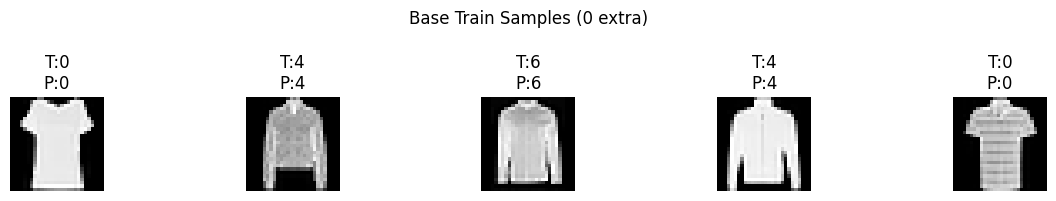

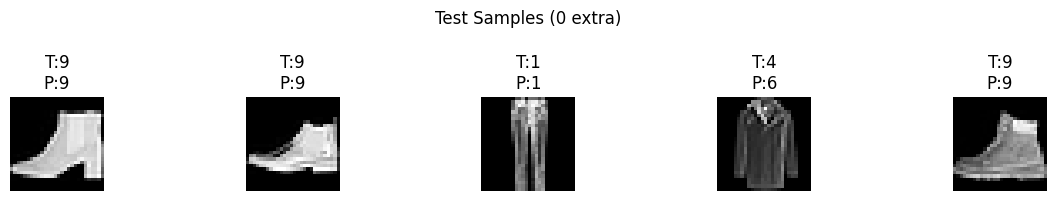

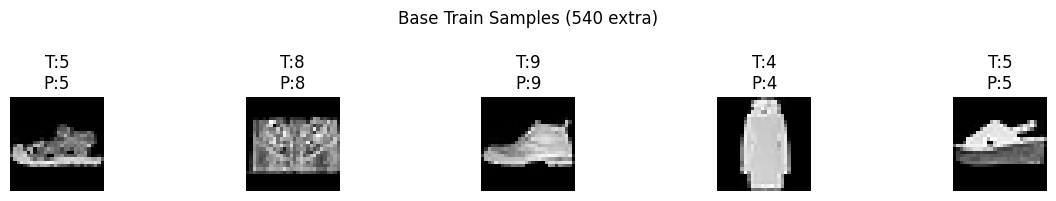

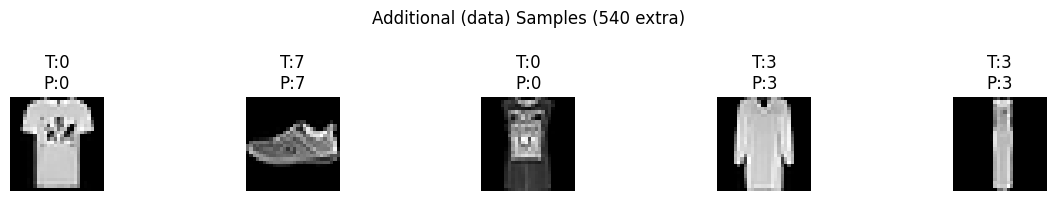

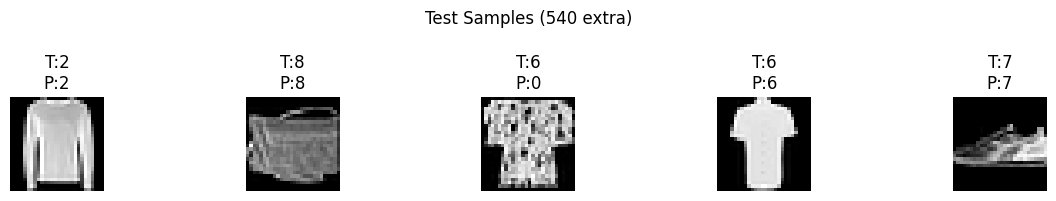

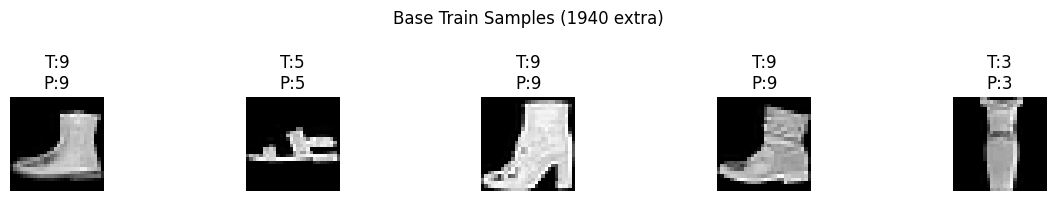

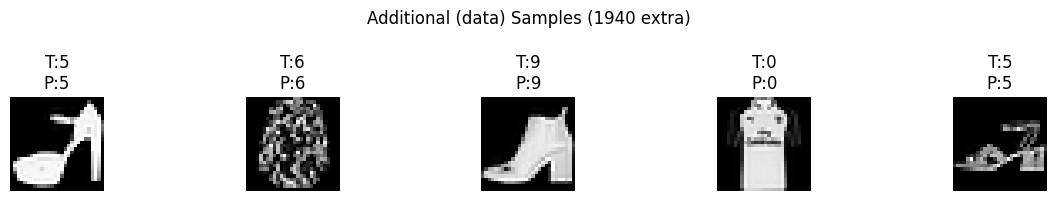

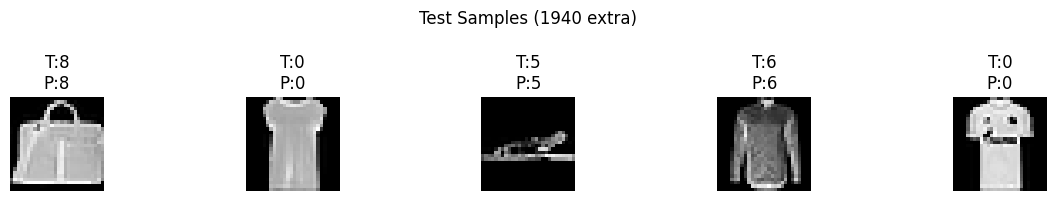

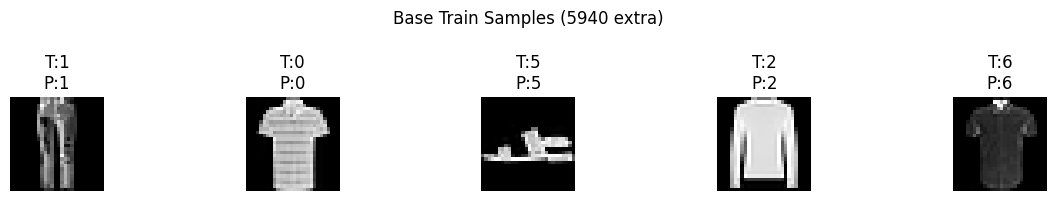

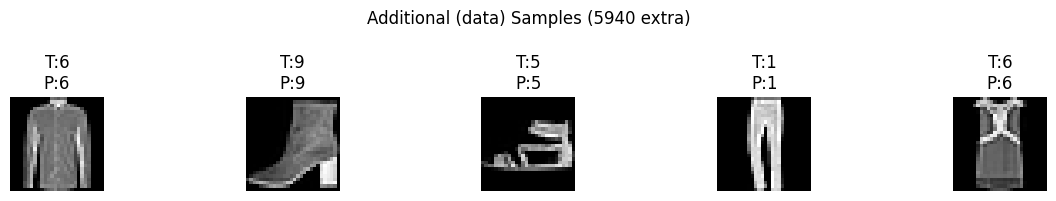

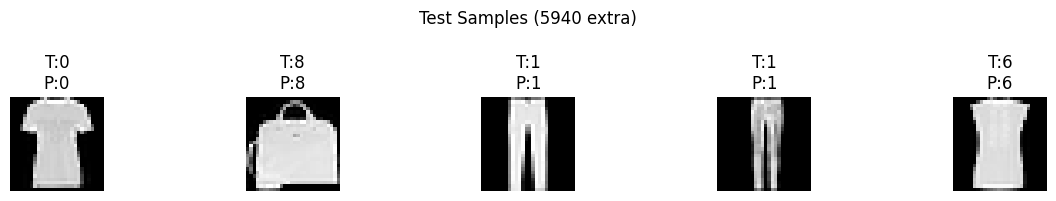

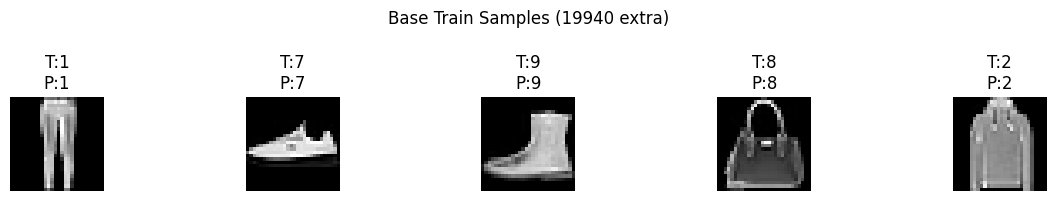

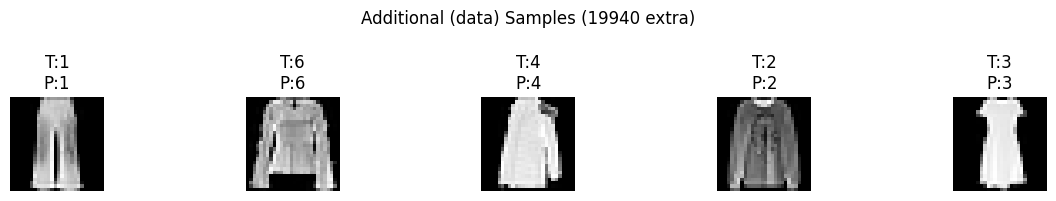

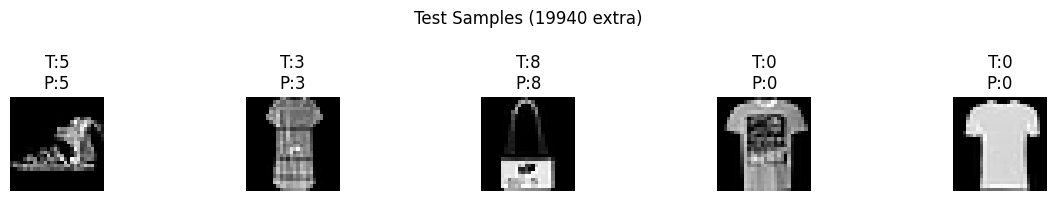

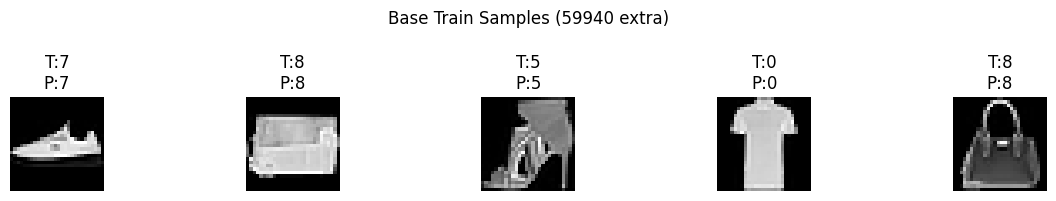

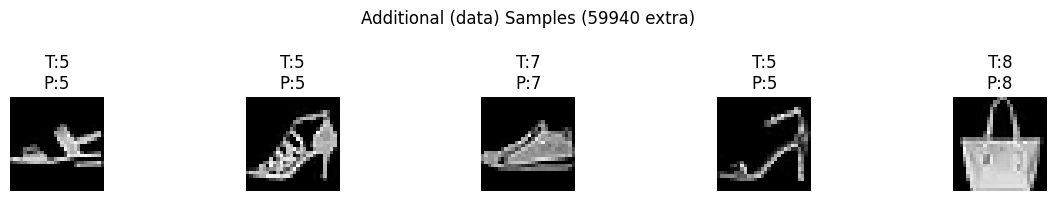

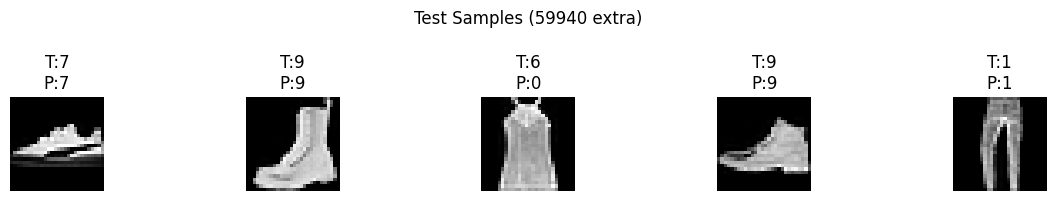

In [6]:
model_module.verify_model_results(
    all_models=all_models,
    x_base_train=x_base_train,
    y_base_train=y_base_train,
    x_additional=x_additional,
    y_additional=y_additional,
    x_test=x_test,
    y_test=y_test,
    dataset_quantities=dataset_quantities,
    dataset_type=dataset_type,
)

## Model Saving

In [7]:
# ====================================
# Save Datasets and Models
# ====================================
output_folder = "models_and_data"
# Save dataset (Possible to skip)
if save_generated_dataset:
    save_dataset(
        folder=output_folder,
        filename="dataset.pt",
        x_base_train=x_base_train,
        y_base_train=y_base_train,
        x_additional=x_additional,
        y_additional=y_additional,
        x_test=x_test,
        y_test=y_test,
        dataset_quantities=dataset_quantities,
        dataset_type=dataset_type,
    )
    print(f"Saved dataset to {output_folder}/dataset.pt")

# Save trained models
if save_generated_models:
    for model_data in all_models:
        filename = f"model_additional_{model_data['additional_data']}.pt"
        save_model(
            folder=output_folder,
            filename=filename,
            model=model_data["model"],
            train_loss=model_data["train_loss"],
            train_accs=model_data["train_accs"],
            test_loss=model_data["test_loss"],
            test_accs=model_data["test_accs"],
            additional_data=model_data["additional_data"],
            dataset_type=model_data["dataset_type"],
        )
        print(f"Saved model: {output_folder}/{filename}")

✅ Dataset saved to models_and_data\dataset.pt
Saved dataset to models_and_data/dataset.pt
✅ Model saved to models_and_data\model_additional_0.pt
Saved model: models_and_data/model_additional_0.pt
✅ Model saved to models_and_data\model_additional_540.pt
Saved model: models_and_data/model_additional_540.pt
✅ Model saved to models_and_data\model_additional_1940.pt
Saved model: models_and_data/model_additional_1940.pt
✅ Model saved to models_and_data\model_additional_5940.pt
Saved model: models_and_data/model_additional_5940.pt
✅ Model saved to models_and_data\model_additional_19940.pt
Saved model: models_and_data/model_additional_19940.pt
✅ Model saved to models_and_data\model_additional_59940.pt
Saved model: models_and_data/model_additional_59940.pt
